## **Set up**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.multitest import multipletests
import glob
from pathlib import Path
import os

In [2]:
import sys
from pathlib import Path

# Get the project root 
project_root = Path.cwd().parent

# Add project root to sys.path
sys.path.append(str(project_root))

## **1. Data Overview**

### 1.1. Load data and basic info

In [3]:
from src.utils import load_data

df = load_data("2015.csv", subfolder="raw")

In [4]:
print(f"Shape: {df.shape}")
print("First few rows")
df.head()

Shape: (441456, 330)
First few rows


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,1.0,1.0,b'01292015',b'01',b'29',b'2015',1200.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0
1,1.0,1.0,b'01202015',b'01',b'20',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,2.0,2.0,3.0,3.0,4.0,2.0,2.0,NaN,NaN,2.0
2,1.0,1.0,b'02012015',b'02',b'01',b'2015',1200.0,2.015000e+09,2.015000e+09,1.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN
3,1.0,1.0,b'01142015',b'01',b'14',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,9.0
4,1.0,1.0,b'01142015',b'01',b'14',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0


In [5]:
print("Columns:", df.columns.tolist())
print("\nInfo:")
print(df.info())

Columns: ['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE', 'SEQNO', '_PSU', 'CTELENUM', 'PVTRESD1', 'COLGHOUS', 'STATERES', 'CELLFON3', 'LADULT', 'NUMADULT', 'NUMMEN', 'NUMWOMEN', 'CTELNUM1', 'CELLFON2', 'CADULT', 'PVTRESD2', 'CCLGHOUS', 'CSTATE', 'LANDLINE', 'HHADULT', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BPMEDS', 'BLOODCHO', 'CHOLCHK', 'TOLDHI2', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'DIABAGE2', 'SEX', 'MARITAL', 'EDUCA', 'RENTHOM1', 'NUMHHOL2', 'NUMPHON2', 'CPDEMO1', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME2', 'INTERNET', 'WEIGHT2', 'HEIGHT3', 'PREGNANT', 'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'SMOKDAY2', 'STOPSMK2', 'LASTSMK2', 'USENOW3', 'ALCDAY5', 'AVEDRNK2', 'DRNK3GE5', 'MAXDRNKS', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN', 'FVORANG', '

In [6]:
from src.brfss_metadata import brfss_data_dict, describe_feature, search_description

print("Data Dict")
print(f"{'Column':<20} {'Dtype':<12} {'Description'}")
print("-" * 120)

for col, row in brfss_data_dict.iterrows():
    # These are the correct column names in your brfss_data_dict
    dtype    = row.get("Data Type", "NA")   # ← "DataType" (no space!)
    desc     = row["Description"]

    # Truncate long descriptions
    if len(desc) > 85:
        desc = desc[:82] + "..."

    # Beautiful aligned output
    print(f"{col:<20} {str(dtype):<12} {desc}")

Data Dict
Column               Dtype        Description
------------------------------------------------------------------------------------------------------------------------
_STATE               float64      State FIPS Code.
FMONTH               float64      File Month.
IDATE                object       Interview Date.
IMONTH               object       Interview Month.
IDAY                 object       Interview Day.
IYEAR                object       Interview Year.
DISPCODE             float64      Final Disposition.
SEQNO                float64      Annual Sequence Number.
_PSU                 float64      Primary Sampling Unit (Equal to Annual Sequence Number).
CTELENUM             float64      Correct Telephone Number?.
PVTRESD1             float64      Is this a private residence? [READ ONLY IF NECESSARY: “By private residence, we me...
COLGHOUS             float64      Do you live in college housing?.
STATERES             float64      Do you reside in ____(state)____?.
CELLFON

### 1.2. Summary Statistics

In [7]:
def data_quality_report(df):
    report = {
        'Total Samples': len(df),
        'Total Features': len(df.columns),
        'Duplicate Rows': df.duplicated().sum(),
        'Memory Usage (MB)': df.memory_usage(deep=True).sum() / 1024**2
    }

    # Data types summary
    dtype_summary = df.dtypes.value_counts()

    return report, dtype_summary

quality_report, dtype_summary = data_quality_report(df)
print("Data Quality Report:")
for key, value in quality_report.items():
    print(f"{key}: {value}")

print("\nData Types Summary:")
print(dtype_summary)

Data Quality Report:
Total Samples: 441456
Total Features: 330
Duplicate Rows: 0
Memory Usage (MB): 1248.200831413269

Data Types Summary:
float64    323
object       7
Name: count, dtype: int64


In [8]:
print(df.describe(include='all'))  # numeric + object columns

               _STATE         FMONTH        IDATE  IMONTH    IDAY    IYEAR  \
count   441456.000000  441456.000000       441456  441456  441456   441456   
unique            NaN            NaN          415      12      31        2   
top               NaN            NaN  b'06022015'   b'03'   b'09'  b'2015'   
freq              NaN            NaN         2148   42406   18669   430541   
mean        29.968715       6.359676          NaN     NaN     NaN      NaN   
std         16.034710       3.487131          NaN     NaN     NaN      NaN   
min          1.000000       1.000000          NaN     NaN     NaN      NaN   
25%         19.000000       3.000000          NaN     NaN     NaN      NaN   
50%         29.000000       6.000000          NaN     NaN     NaN      NaN   
75%         44.000000       9.000000          NaN     NaN     NaN      NaN   
max         72.000000      12.000000          NaN     NaN     NaN      NaN   

             DISPCODE         SEQNO          _PSU  CTELENUM  ..

## **2. Missing Values & Constant Features**

### 2.1. Checking constant features

In [9]:
# Select columns with only one unique value
single_value_cols = df.columns[df.nunique() == 1]
print(f"Number of columns with a single unique value: {len(single_value_cols)}")
print(f"Columns with a single unique value: {single_value_cols}")


Number of columns with a single unique value: 5
Columns with a single unique value: Index(['CTELENUM', 'COLGHOUS', 'STATERES', 'CTELNUM1', 'CCLGHOUS'], dtype='object')


**Recommendation**

Drop all columns with a single unique value: `CTELENUM`, `COLGHOUS`, `STATERES`, `CTELNUM1`, `CCLGHOUS`

### 2.2. Checking missing values

In [10]:
# Columns with missing data
missing_cols = df.columns[df.isnull().any()]

# Count missing values per column
missing_counts = df[missing_cols].isnull().sum()

# Percentage missing per column
missing_percent = (df[missing_cols].isnull().mean() * 100)

high_missing = missing_percent[missing_percent > 50].sort_values(ascending=False)  # more than 50% missing
medium_missing = missing_percent[(missing_percent <= 50) & (missing_percent > 10)].sort_values(ascending=False)
low_missing = missing_percent[missing_percent <= 10].sort_values(ascending=False)

print("High missing (>50%)", high_missing.shape[0])
print("Medium missing (10-50%)", medium_missing.shape[0])
print("Low missing (<=10%)", low_missing.shape[0])


High missing (>50%) 150
Medium missing (10-50%) 35
Low missing (<=10%) 59


In [11]:
def print_missing_with_desc(title: str, series):
    print(f"\n{title} ({len(series)} columns)")
    print("-" * 110)
    for col in series.index:
        miss_pct = missing_percent[col]
        if col in brfss_data_dict.index:
            desc = brfss_data_dict.loc[col, "Description"]
            if len(desc) > 80:
                desc = desc[:77] + "..."
        else:
            desc = "(no description in metadata)"
        print(f"{col:<16} │ {miss_pct:>6.1f}% │ {desc}")

print_missing_with_desc("High missing (>50%)",     high_missing)
print_missing_with_desc("Medium missing (10–50%)", medium_missing)
print_missing_with_desc("Low missing (≤10%)",      low_missing)


High missing (>50%) (150 columns)
--------------------------------------------------------------------------------------------------------------
QLMENTL2         │  100.0% │ During the past 30 days, for about how may days have you felt sad, blue, or d...
PAINACT2         │  100.0% │ During the past 30 days, for about how many days did pain make it hard for yo...
QLHLTH2          │  100.0% │ During the past 30 days, for about how many days have you felt very healthy a...
QLSTRES2         │  100.0% │ During the past 30 days, for about how many days have you felt worried, tense...
COLGHOUS         │  100.0% │ Do you live in college housing?.
LADULT           │  100.0% │ Are you 18 years of age or older?.
ASDRVIST         │   99.9% │ During the past 12 months, how many times did you see a doctor, nurse or othe...
ASERVIST         │   99.9% │ During the past 12 months, how many times did you visit an emergency room or ...
ASNOSLEP         │   99.9% │ During the past 30 days, how many days 

**Missing Data Handling Recommendation**

| Missing Level       | % Missing     | # Columns |Recommended Action                                 |
|---------------------|---------------|----------------------------------------------------|-----------------------------------------------------|
| High            | > 50%         | 150        | Consider Dropping (unless domain-critical)                   |
| Medium          | 10% – 50%     | 35        | Conditional imputation or drop                      |
| Low             | ≤ 10%         | 59       | Impute (simple or advanced)                         |

**Missingness Mechanism Guide**

| Type  | Meaning                                 |  Recommended Handling                                      |
|-------|-----------------------------------------|------------------------------------------------------------|
| MCAR  | Missing completely at random            | Random survey skip                                     | Simple imputation (mean/median/mode) or drop               |
| MAR   | Missing at random (depends on observed) | Conditional imputation (by group) or MICE              |
| MNAR  | Missing not at random (informative)     |  Create missing indicator + impute (median/'Missing')   |

**Rationale**:  
- 48 columns have >50% missing → mostly “specify other” text fields and child-module questions  
- Most high-missing variables are structurally absent (MAR), not random  
- Keeping them would introduce noise; dropping them is standard practice in BRFSS literature

**Next steps**:  
```python
cols_to_drop = high_missing.index.tolist() + child_module_cols
df_clean = df.drop(columns=cols_to_drop)

## **3. Target Variable Exploration**

In [12]:
target = "_MICHD"

### 3.1. Distribution of targets

In [13]:
df[target].value_counts()

_MICHD
2.0    398881
1.0     38633
Name: count, dtype: int64

Number of people with cardiovascular disease: 38,633
Number of people without cardiovascular disease: 398,881
Total respondents: 441,456
Prevalence of reported CHD/MI: 8.75%


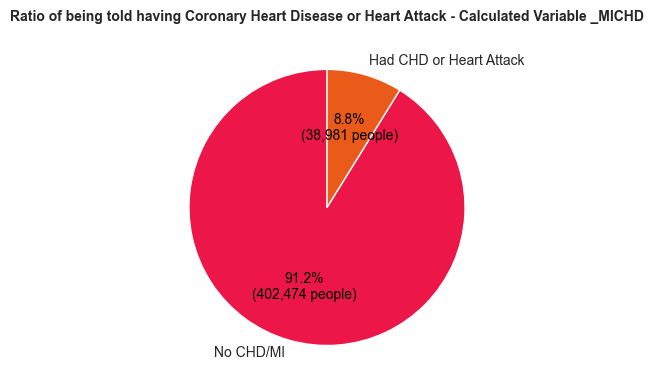

In [14]:
n_total = len(df[target])

# Counts
count_yes = (df[target] == 1).sum()
count_no  = (df[target] == 2).sum()
prevalence = count_yes / n_total * 100

print(f"Number of people with cardiovascular disease: {count_yes:,}")
print(f"Number of people without cardiovascular disease: {count_no:,}")
print(f"Total respondents: {n_total:,}")
print(f"Prevalence of reported CHD/MI: {prevalence:.2f}%")


plt.figure(figsize=(8, 4))
sns.set_style("white")

colors = ["#EC1648", "#EA5B19"] 

wedges, texts, autotexts = plt.pie(
    [count_no, count_yes],
    labels=['No CHD/MI', 'Had CHD or Heart Attack'],
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100 * n_total):,} people)',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)

# Make percentage bold and dark
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)

plt.title("Ratio of being told having Coronary Heart Disease or Heart Attack - Calculated Variable _MICHD", 
          fontsize=10, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

### 3.2. Imbalance Interpretation

- The dataset shows a severe class imbalance, with only about ~8.8% of respondents reporting a Coronary Heart Disease or Heart Attack (`_MICHD = Yes`).
- This imbalance increases the risk that machine learning models will become biased toward predicting the majority class ("No").  
- In this context, accuracy is not a reliable metric, since even a naive model that always predicts "No" would achieve about ~91.2% accuracy.  

### 3.3. Implication for Modeling

**Next Steps:**
1. Resampling strategies:
   - Oversample minority class (e.g., SMOTE)
   - Undersample majority class
   - Use class weighting (`class_weight='balanced'` in sklearn)
2. Stratified splitting: Use stratified train/test splits to preserve the original imbalance ratio across datasets
3. Feature analysis: Compare distributions of key features between "Yes" and "No" groups to identify discriminative patterns
4. Threshold tuning: Optimize classification threshold (default 0.5) using validation metrics

**Medical Context Note**: In heart attack prediction, *false negatives* (missing actual cases) are particularly dangerous. Prioritize high recall while monitoring precision to avoid excessive false alarms. Using `SMOTE` or `class weighting` is recommended to address this imbalance.


## **4. Univariate Analysis**

cái này là drop trước mấy cái 100% không quan trọng: như ngày tháng năm khảo sát, mấy cái biến bài tập thể dục mà lát sau đưa vào biến khác rồi, và nhà có bao nhiêu trẻ em, tình trạng mang thai (tao nghĩ không quan trọng nhưng nếu m thấy k hợp lý thì xóa), và tất nhiên mấy biến missing 100% và mấy biến chỉ có 1 giá trị

### Drops obvious unimportant features before univariate analysis

In [15]:
# Intial dropping
to_drop = [
    # Survey administration & design 
    'FMONTH','IDATE','IMONTH','IDAY','IYEAR','DISPCODE','SEQNO','_PSU','_STSTR',
    '_STRWT','_RAWRAKE','_WT2RAKE','_LLCPWT','_CLLCPWT','_DUALCOR','_DUALUSE',
    'QSTVER','QSTLANG',
    
    # Open-ended / raw activity (already summarized in clean vars) 
    'EXRACT11','EXRACT21','EXEROFT1','EXEROFT2','EXERHMM1','EXERHMM2',
    
    # Child / pregnancy sections (different population)
    'RCSGENDR','RCSRLTN2','CASTHDX2','CASTHNO2','PREGNANT'
]
extreme_missing = list(missing_percent[missing_percent == 100].sort_values(ascending=False).index) 
df_clean = df.drop(columns=to_drop + extreme_missing + list(single_value_cols))
df_clean.shape

(441456, 292)

In [16]:
num_cols = df_clean.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df_clean.select_dtypes(include=['object','category','bool']).columns.tolist()

num_cols = [c for c in num_cols if c != target]  
print(f'Number of categorical features: {len(cat_cols)}')
print(f'Number of numerical features: {len(num_cols)}')

Number of categorical features: 3
Number of numerical features: 288


### 4.1. Encode categorical features

In [40]:
for col in cat_cols:
    print(df[col].value_counts())

PCDMDECN
b''        441201
b'1'          208
b'2'           21
b'12'           7
b'4'            5
b'9'            4
b'7'            3
b'3'            2
b'21'           2
b'13'           1
b'1234'         1
b'14'           1
Name: count, dtype: int64
EXACTOT1
b''                    428378
b'cardio'                 410
b'treadmill'              380
b'TREADMILL'              318
b'physical therapy'       226
                        ...  
b'aerobicos'                1
b'quica'                    1
b'balonmano'                1
b'artes marciales'          1
b'martal arts'              1
Name: count, Length: 5642, dtype: int64
EXACTOT2
b''              424831
b'stretching'       349
b'STRETCHING'       267
b'treadmill'        240
b'cardio'           213
                  ...  
b'roll march'         1
b'barbel'             1
b'VOLLEYBALL'         1
b'STREACHING'         1
b'airsoft'            1
Name: count, Length: 7623, dtype: int64


Nên bỏ 2 cột `EXACTOT1` và `EXACTOT2`

→ Vì chúng là cột text tự do (free-text), chứa mô tả chi tiết và không phân biệt viết hoa viết thường

Chúng đã được thay thế bằng những cột nào (rõ ràng hơn & mạnh hơn rất nhiều) như PhysicalActivities

đơn giản là vẽ bar chart của 3 biến categorical, và chọn 10 values trong từng features mà có tần suất nhiều nhất tại mấy feature này chia nhiều mục

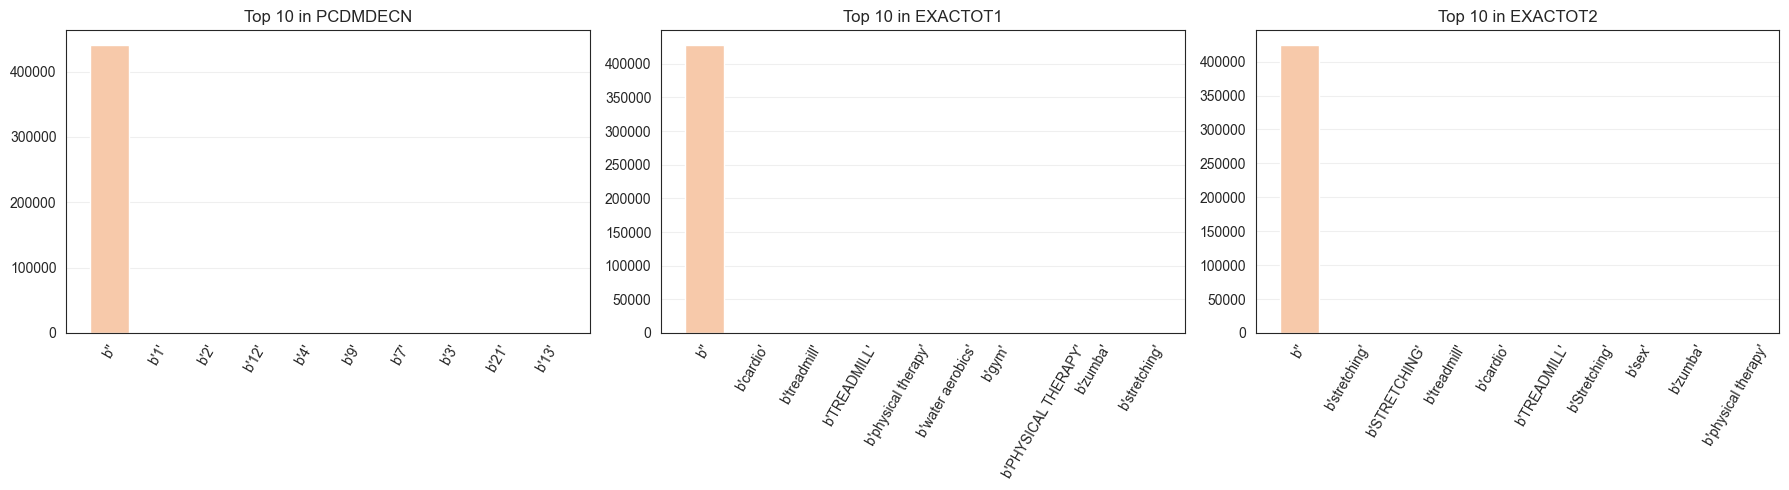

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

top_n =  10   # top values inside each feature
n_cols = len(cat_cols)   # one subplot per feature
fig, axes = plt.subplots(1, n_cols, figsize=(6*n_cols, 5))

# If only one feature, axes won't be iterable
if n_cols == 1:
    axes = [axes]

for ax, col in zip(axes, cat_cols):
    # Get top N frequent values for this feature
    top_vals = df_clean[col].value_counts().head(top_n)

    # Colors
    colors = sns.color_palette('rocket_r', n_colors=len(top_vals))

    # Bar plot
    ax.bar(top_vals.index, top_vals.values, color=colors)
    ax.set_title(f"Top {top_n} in {col}", fontsize=12)
    ax.tick_params(axis='x', rotation=60)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### 4.2. Numerical Features

vì không thể ngồi plot hết 290 feature nên t quyết định lọc bớt feature

Pearson correlation ổn với quan hệ tuyến tính cơ mà chỉ bắt được quan hệ tuyến tính, bỏ sót quan hệ phi tuyến
Mutual Information bắt được cả tuyến tính lẫn phi tuyến, nhạy cảm với nhiễu, cardinality cao.
Nếu chỉ dùng 1 trong 2, dễ bỏ sót hoặc chọn nhầm các feature thực sự mạnh.

Nên là: Tính correlation đại diện cho mối quan hệ tuyến tính mạnh.
Tính mutual information đại diện cho mối quan hệ tổng quát (kể cả phi tuyến)
Gộp lại, lấy trung bình điểm -> feature nào cả hai metric đều đánh giá cao thì chắc chắn quan trọng
. feature nào chỉ một trong hai thích thì sẽ bị kéo điểm xuống -> giảm false positive
Top 40 là con số vừa đủ để vẽ heatmap, pairplot, distribution plot chi tiết mà không bị quá tải.

top 40 đấy, đừng chạy code, 30-40' đó:
chạy cái dưới thôi, đừng cái sau

In [18]:
# Create a clean version for MI calculation (no NaN in features or target)
df_mi = df_clean[num_cols + [target]].copy()

# Fill numeric features with median
df_mi[num_cols] = df_mi[num_cols].fillna(df_mi[num_cols].median())

# If target still has NaN after filling features, you must handle it:
if df_mi[target].isna().any():
    # Either drop rows with missing target
    df_mi = df_mi.dropna(subset=[target])
    print(f"Dropped {df_clean[target].isna().sum()} rows with missing target.")
top_num = ['CVDINFR4', 'CVDCRHD4', 'CVDASPRN', 'LADULT', 'GENHLTH', 'BPHIGH4', 'DIABETE3', '_AGE80', '_AGEG5YR', '_DRDXAR1', 'EMPLOY1', '_AGE_G', '_HCVU651', 'DRADVISE', 'ASERVIST', 'USEEQUIP', '_RFHLTH', '_AGE65YR', '_RFHYPE5', 'ARTTODAY', 'CDASSIST', 'VICTRCT4', 'CDHOUSE', 'DIFFWALK', 'LASTPAP2', 'CHCCOPD1', 'VIREDIF3', 'CHILDREN', 'ASPUNSAF', 'CDSOCIAL', 'QLACTLM2', 'CVDSTRK3', 'VETERAN3', 'PCPSADE1', 'TOLDHI2', 'HAVARTH3', 'DIFFALON', 'ARTHSOCL', 'WTCHSALT', 'ACTIN11_']

Dropped 3942 rows with missing target.


In [19]:
# from sklearn.feature_selection import mutual_info_classif
# import pandas as pd
# import numpy as np

# # Create a clean version for MI calculation (no NaN in features or target)
# df_mi = df_clean[num_cols + [target]].copy()

# # Fill numeric features with median
# df_mi[num_cols] = df_mi[num_cols].fillna(df_mi[num_cols].median())

# # If target still has NaN after filling features, you must handle it:
# if df_mi[target].isna().any():
#     # Either drop rows with missing target
#     df_mi = df_mi.dropna(subset=[target])
#     print(f"Dropped {df_clean[target].isna().sum()} rows with missing target.")
    
#     # Or fill target (only if it makes sense — usually NOT recommended for target!)
#     # df_mi[target] = df_mi[target].fillna(df_mi[target].mode()[0])

# # Now both X and y are clean
# X_mi = df_mi[num_cols]
# y_mi = df_mi[target]

# # Correlation (absolute) with target — using original df_clean is fine
# # (since .corrwith handles NaN by skipping)
# corr_scores = df_clean[num_cols].corrwith(df_clean[target]).abs()

# # Mutual Information
# mi_scores = mutual_info_classif(X_mi, y_mi, random_state=42)  # add random_state for reproducibility
# mi_scores = pd.Series(mi_scores, index=num_cols, name='mi')

# # Combine
# feature_rank = pd.concat([corr_scores.rename('corr'), mi_scores], axis=1)

# # Handle possible NaN in correlation (if a column has no variation or all NaN)
# feature_rank['corr'] = feature_rank['corr'].fillna(0)

# # Average score (you can also use rank-based averaging for more robustness)
# feature_rank['score'] = feature_rank.mean(axis=1)

# # Select top 40
# top_num = feature_rank.sort_values(by='score', ascending=False).head(40).index.tolist()

# print("Top 40 numeric features for univariate EDA:")
# print(top_num)
# print("\nDetailed ranking:")
# print(feature_rank.sort_values(by='score', ascending=False).head(40))

xem lại cái tổng quan missing , unique, rồi min, max từng cái

In [20]:
num_summary = df_clean[top_num].describe().T
num_summary['missing_%'] = df_clean[top_num].isna().mean() * 100
num_summary['skewness'] = df_clean[top_num].skew()
num_summary['kurtosis'] = df_clean[top_num].kurt()
num_summary['unique'] = df_clean[top_num].nunique()
num_summary = num_summary[['count', 'unique', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis', 'missing_%']]
num_summary.round(2)

,count,unique,mean,std,min,25%,50%,75%,max,skewness,kurtosis,missing_%
CVDINFR4,441456.0,4,1.97,0.44,1.0,2.0,2.0,2.0,9.0,8.07,105.84,0.00
CVDCRHD4,441455.0,4,1.99,0.53,1.0,2.0,2.0,2.0,9.0,7.51,75.85,0.00
CVDASPRN,18798.0,4,1.71,0.51,1.0,1.0,2.0,2.0,9.0,1.49,23.93,95.74
LADULT,45.0,2,1.60,0.50,1.0,1.0,2.0,2.0,2.0,-0.42,-1.91,99.99
GENHLTH,441454.0,7,2.58,1.12,1.0,2.0,2.0,3.0,9.0,0.60,0.77,0.00
BPHIGH4,441455.0,6,2.21,1.04,1.0,1.0,3.0,3.0,9.0,0.18,0.99,0.00
DIABETE3,441449.0,6,2.76,0.72,1.0,3.0,3.0,3.0,9.0,-1.20,5.72,0.00
_AGE80,441456.0,63,55.41,17.04,18.0,43.0,58.0,69.0,80.0,-0.41,-0.80,0.00
_AGEG5YR,441456.0,14,7.80,3.50,1.0,5.0,8.0,10.0,14.0,-0.31,-0.84,0.00
_DRDXAR1,438657.0,2,1.66,0.47,1.0,1.0,2.0,2.0,2.0,-0.69,-1.53,0.63


plot mấy feature mới ra

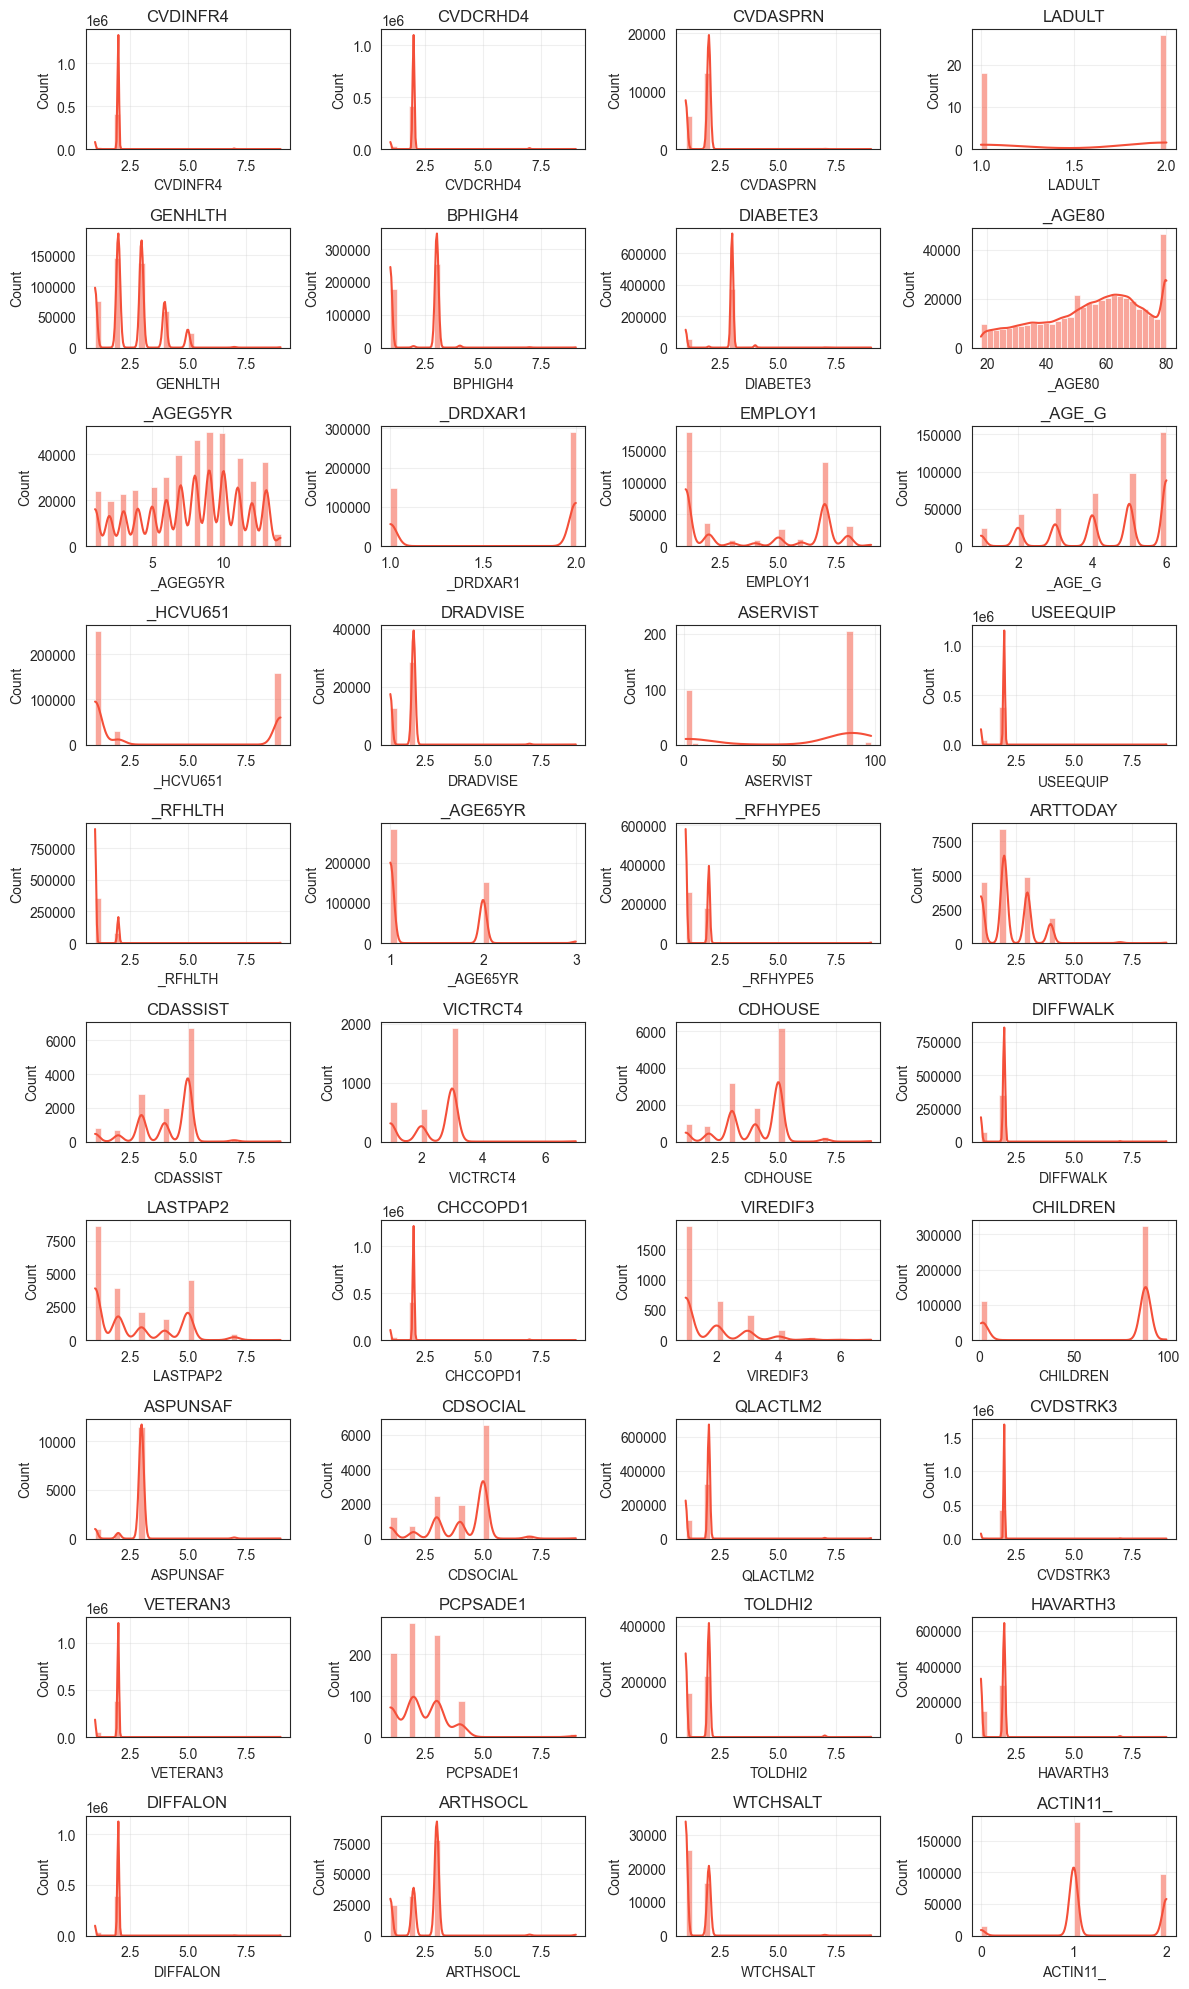

In [21]:
n = len(top_num)
rows = (n + 1) // 4
fig, axes = plt.subplots(rows, 4, figsize=(12, rows * 2))
axes = axes.flatten()
red_color = sns.color_palette("Reds", 6)[3]  # màu đỏ trung tính

for i, col in enumerate(top_num):
    sns.histplot(df_clean[col].dropna(), bins=30, kde=True, color=red_color, ax=axes[i])
    axes[i].set_title(col)
    axes[i].grid(alpha=0.3)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Một số feature có chỉ có vài giá trị rời rạc, thay vì phân phối liên tục mượt mà. 

-> dấu hiệu của biến categorical bị nhầm thành numerical.

vậy nên ở dưới t quyết định kiểm tra bằng cách xem mấy features mà chỉ có < 20 giá trị unique thì có khả năng cao là categorical đặc biệt với nhiều quan sát như thế

In [31]:
# Kiểm tra số unique values
for col in df.columns:
    n_unique = df[col].nunique()
    if n_unique < 20: 
        print(f"{col}: {n_unique} unique values -> potential categorical!")

FMONTH: 12 unique values -> potential categorical!
IMONTH: 12 unique values -> potential categorical!
IYEAR: 2 unique values -> potential categorical!
DISPCODE: 2 unique values -> potential categorical!
CTELENUM: 1 unique values -> potential categorical!
PVTRESD1: 2 unique values -> potential categorical!
COLGHOUS: 1 unique values -> potential categorical!
STATERES: 1 unique values -> potential categorical!
CELLFON3: 2 unique values -> potential categorical!
LADULT: 2 unique values -> potential categorical!
NUMADULT: 17 unique values -> potential categorical!
NUMMEN: 12 unique values -> potential categorical!
NUMWOMEN: 11 unique values -> potential categorical!
CTELNUM1: 1 unique values -> potential categorical!
CELLFON2: 2 unique values -> potential categorical!
CADULT: 2 unique values -> potential categorical!
PVTRESD2: 2 unique values -> potential categorical!
CCLGHOUS: 1 unique values -> potential categorical!
CSTATE: 2 unique values -> potential categorical!
LANDLINE: 4 unique val

các feature này nên được kiểm tra lại để tránh gán số trực tiếp cho những categorical không có thứ bậc

vì các feature đa phần bị phân phối lệch hoặc không rõ ràng nên dùng iqr để kiểm tra outlier

Kết hợp: IQR để khám phá + Isolation Forest để phát hiện đa biến
Bước 1: Dùng IQR để xem từng biến có giá trị cực đoan nào — kiểm tra xem có phải lỗi nhập liệu hay không (ví dụ: nhịp tim = 300 → sai).
Bước 2: Dùng Isolation Forest để tìm điểm bất thường trong không gian 40 chiều — có thể phát hiện tổ hợp nguy cơ bất thường dù từng biến vẫn “bình thường”.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest


# ==================== BƯỚC 1: IQR để bắt lỗi nhập liệu (ngưỡng rộng k=3.0) ====================
def flag_gross_errors_iqr(df, cols, k=3.0):
    flags = np.zeros(len(df), dtype=bool)
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        flags |= (df[col] < lower) | (df[col] > upper)
    return flags

gross_errors = flag_gross_errors_iqr(df_mi, top_num, k=3.0)
print(f"Step 1 - Gross errors (có thể là lỗi nhập liệu): {gross_errors.sum()} mẫu")

# ==================== BƯỚC 2: Isolation Forest – phát hiện bất thường đa biến ====================
features_iso = df_mi[top_num]

iso = IsolationForest(
    contamination=0.015,
    n_estimators=500,
    max_samples='auto',
    random_state=42,
    n_jobs=-1
)

iso.fit(features_iso)

df_mi['iso_score'] = iso.decision_function(features_iso)
df_mi['iso_outlier'] = iso.predict(features_iso) == -1  # dùng .predict(), KHÔNG phải .fit_predict()

print(f"Step 2 - Isolation Forest detect: {df_mi['iso_outlier'].sum()} outliers đa biến")

Step 1 - Gross errors (có thể là lỗi nhập liệu): 299585 mẫu
Step 2 - Isolation Forest detect: 6563 outliers đa biến


sai lệch dữ liệu nhiều như này cũng cho thấy categorize dữ liệu nhầm từ category -> numerical nhiều

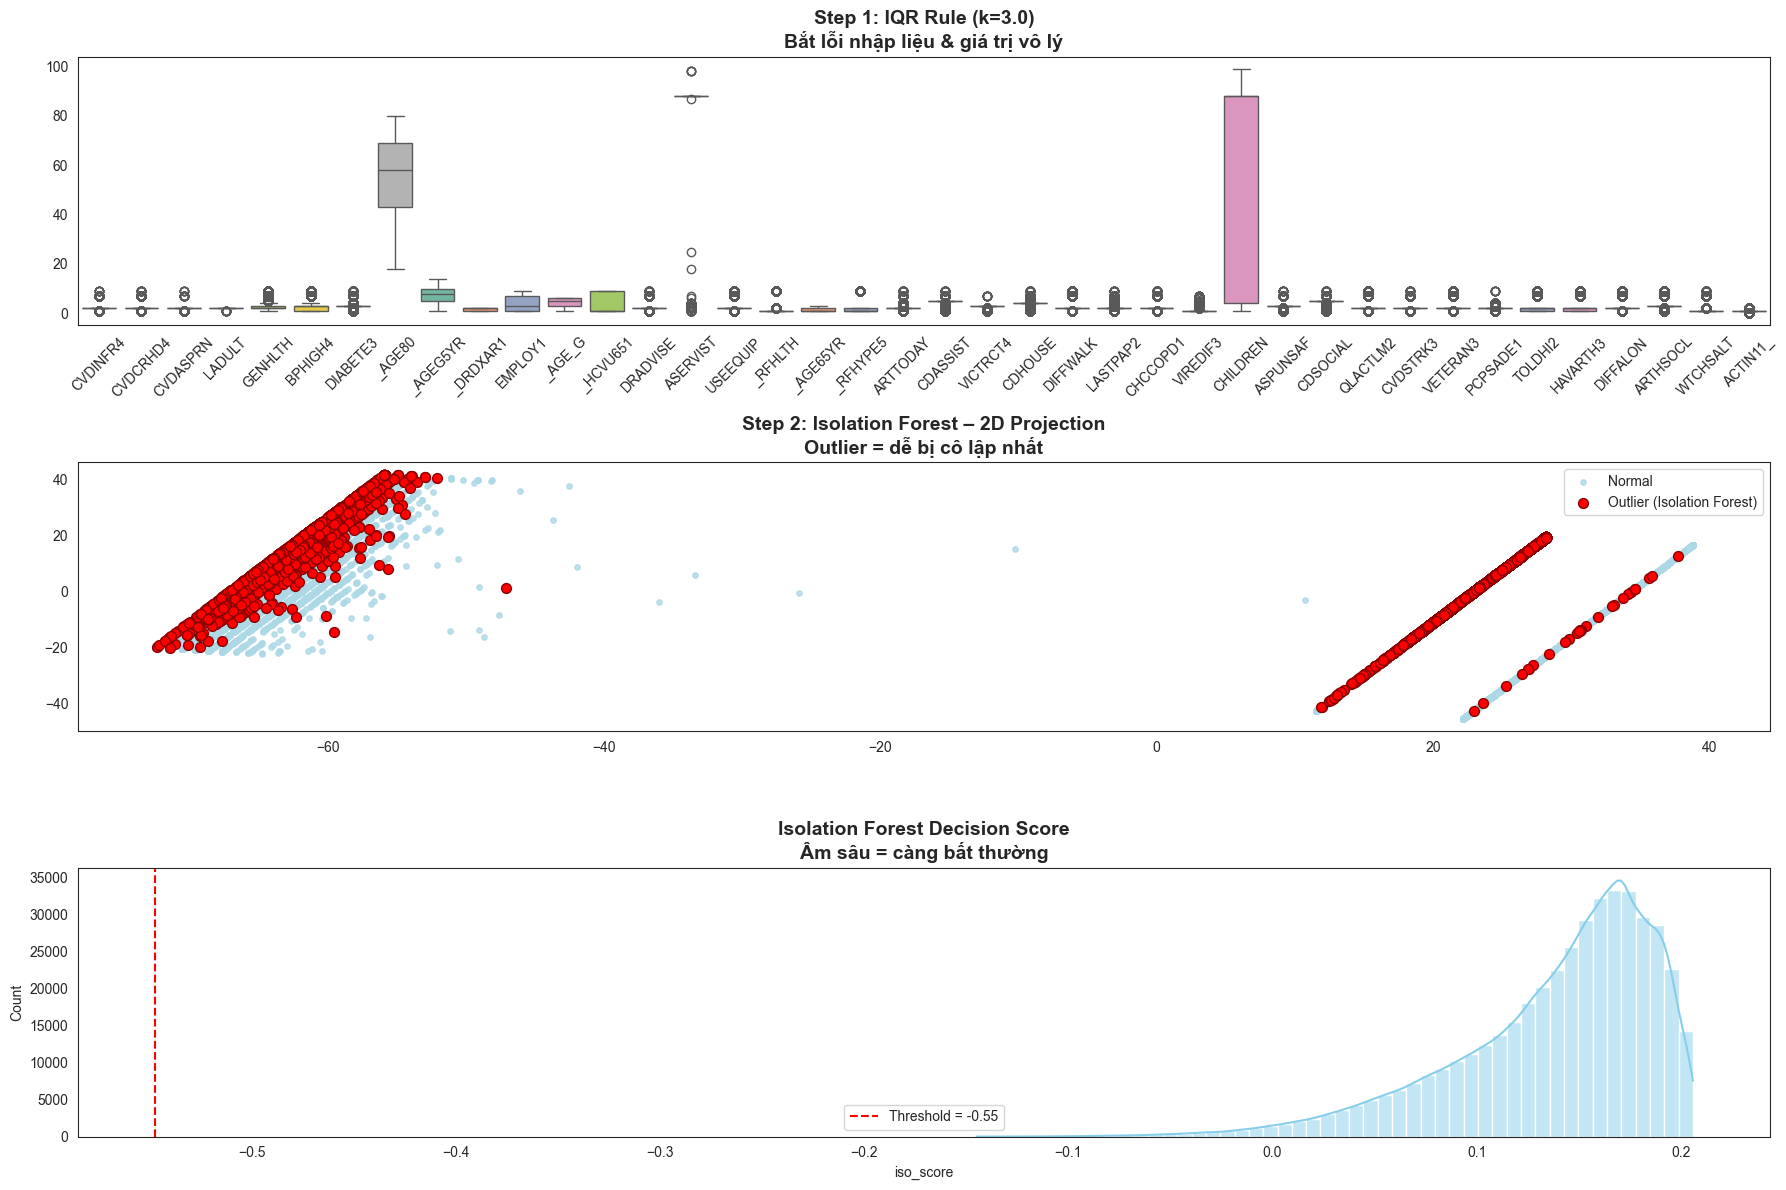

In [23]:
from sklearn.decomposition import PCA

fig, axes = plt.subplots(3, 1, figsize=(18, 12))  # tăng height để đủ chỗ

# 1. IQR intuition
sns.boxplot(data=df_mi[top_num], ax=axes[0], palette="Set2")
axes[0].set_title("Step 1: IQR Rule (k=3.0)\nBắt lỗi nhập liệu & giá trị vô lý", fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# 2. Isolation Forest intuition (2D projection)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(features_iso)

# Giả sử bạn đã có cột 'iso_outlier' trong df_mi (boolean)
normal_mask = ~df_mi['iso_outlier']
axes[1].scatter(X_2d[normal_mask, 0], X_2d[normal_mask, 1], 
                c='lightblue', s=15, alpha=0.8, label='Normal')
axes[1].scatter(X_2d[~normal_mask, 0], X_2d[~normal_mask, 1], 
                c='red', s=50, edgecolors='darkred', label='Outlier (Isolation Forest)')
axes[1].set_title("Step 2: Isolation Forest – 2D Projection\nOutlier = dễ bị cô lập nhất", 
                  fontsize=14, fontweight='bold')
axes[1].legend()

# 3. Score distribution
sns.histplot(df_mi['iso_score'], bins=50, ax=axes[2], color='skyblue', kde=True)
# Lưu ý: sklearn IsolationForest.decision_function trả giá trị càng LỚN → càng bình thường
# => Điểm bất thường có decision_function < 0, và thường < threshold
threshold = iso.offset_  # hoặc bạn dùng giá trị bạn đã đặt khi fit (contamination)
axes[2].axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.2f}')
axes[2].set_title("Isolation Forest Decision Score\nÂm sâu = càng bất thường", fontsize=14, fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

Step 1: IQR Rule (k=3.0) — Bắt lỗi nhập liệu & giá trị vô lý

Mỗi hộp (boxplot) đại diện cho một biến số trong dataset.
Những điểm tròn nhỏ ngoài box là outlier theo IQR.
K = 3.0 → ngưỡng rộng hơn so với k=1.5 → chỉ bắt những giá trị cực đoan thật sự (giảm false positive).
Quan sát:
Biến CHILDREN có một outlier cực lớn (giá trị ~90) — rất đáng ngờ!
Trong y khoa, số con không thể là 90 → lỗi nhập liệu → cần kiểm tra lại.
Biến _AGE80, DIABETE3, BPHIGH4... có vài điểm outlier nhỏ → có thể là giá trị thực tế nhưng hiếm (ví dụ: người 80+ tuổi, hoặc huyết áp cao).
Một số biến như CVDINFR4, CVDCRHD4... gần như không có outlier → dữ liệu sạch.

Hành động: 

Xóa hoặc sửa các outlier vô lý (như CHILDREN = 90).
Giữ lại các outlier có ý nghĩa lâm sàng (tuổi cao, huyết áp cao...) — vì đó là đặc trưng của bệnh nhân CVD.

Step 2: Isolation Forest – 2D Projection — Outlier = dễ bị cô lập nhất
Ý nghĩa:
Dữ liệu 40 chiều được giảm xuống 2D bằng PCA để vẽ.

Các điểm xanh nhạt = bình thường.

Các điểm đỏ = outlier theo Isolation Forest -> dễ bị cô lập nhất trong không gian 40D.
Quan sát:
Phần lớn điểm nằm trong cụm dày đặc -> bình thường.
Có một nhóm điểm đỏ nằm rải rác ở rìa -> đây là các ca tổ hợp bất thường.
Có một dải điểm đỏ kéo dài ở góc phải dưới -> có thể là một kiểu mẫu đặc biệt (ví dụ: bệnh nhân trẻ tuổi nhưng có nhiều yếu tố nguy cơ cùng lúc).

Hành động: 

Không xóa các điểm đỏ này 
Nếu là ca bệnh thật -> giữ lại, thậm chí có thể tạo feature mới (“high-risk combo”) để tăng hiệu quả mô hình.

Step 3: Isolation Forest Decision Score — Âm sâu = càng bất thường
Ý nghĩa:
Trục X: Decision score từ Isolation Forest.
Âm sâu (ví dụ: -0.55) → càng bất thường.
Gần 0 hoặc dương → càng bình thường.
Thanh đỏ đứt đoạn: ngưỡng phân loại (threshold = -0.55)
Hầu hết điểm tập trung ở phía dương → dữ liệu chủ yếu là bình thường.
Có một “đuôi trái” mỏng → những điểm cực kỳ bất thường.

Hành động: 

có thể gán nhãn outlier bằng cách:

```python

df_mi['is_outlier'] = df_mi['iso_score'] < -0.55
```
Gợi ý :
Tạo cột risk_level từ outlier score:
```python

df_mi['risk_level'] = pd.cut(df_mi['iso_score'], 
                            bins=[-np.inf, -0.55, 0, np.inf], 
                            labels=['High', 'Medium', 'Low'])
```
So sánh tỷ lệ CVD giữa nhóm outlier vs normal → nếu nhóm outlier có tỷ lệ CVD cao hơn → chứng tỏ outlier là dấu hiệu lâm sàng quan trọng!

## **5. Multivariate Analysis**

### Heatmap correlation of numerical features

cái corr map t tính rocket_r nhưng thử thì nó nhìn hơi khó phân biệt nên tạm để màu gần giống

với cả cái này vẫn chỉ xét top 40 feature thôi

còn categorical coi như k phân tích nữa vì 2 biến kia hơi vô nghĩa

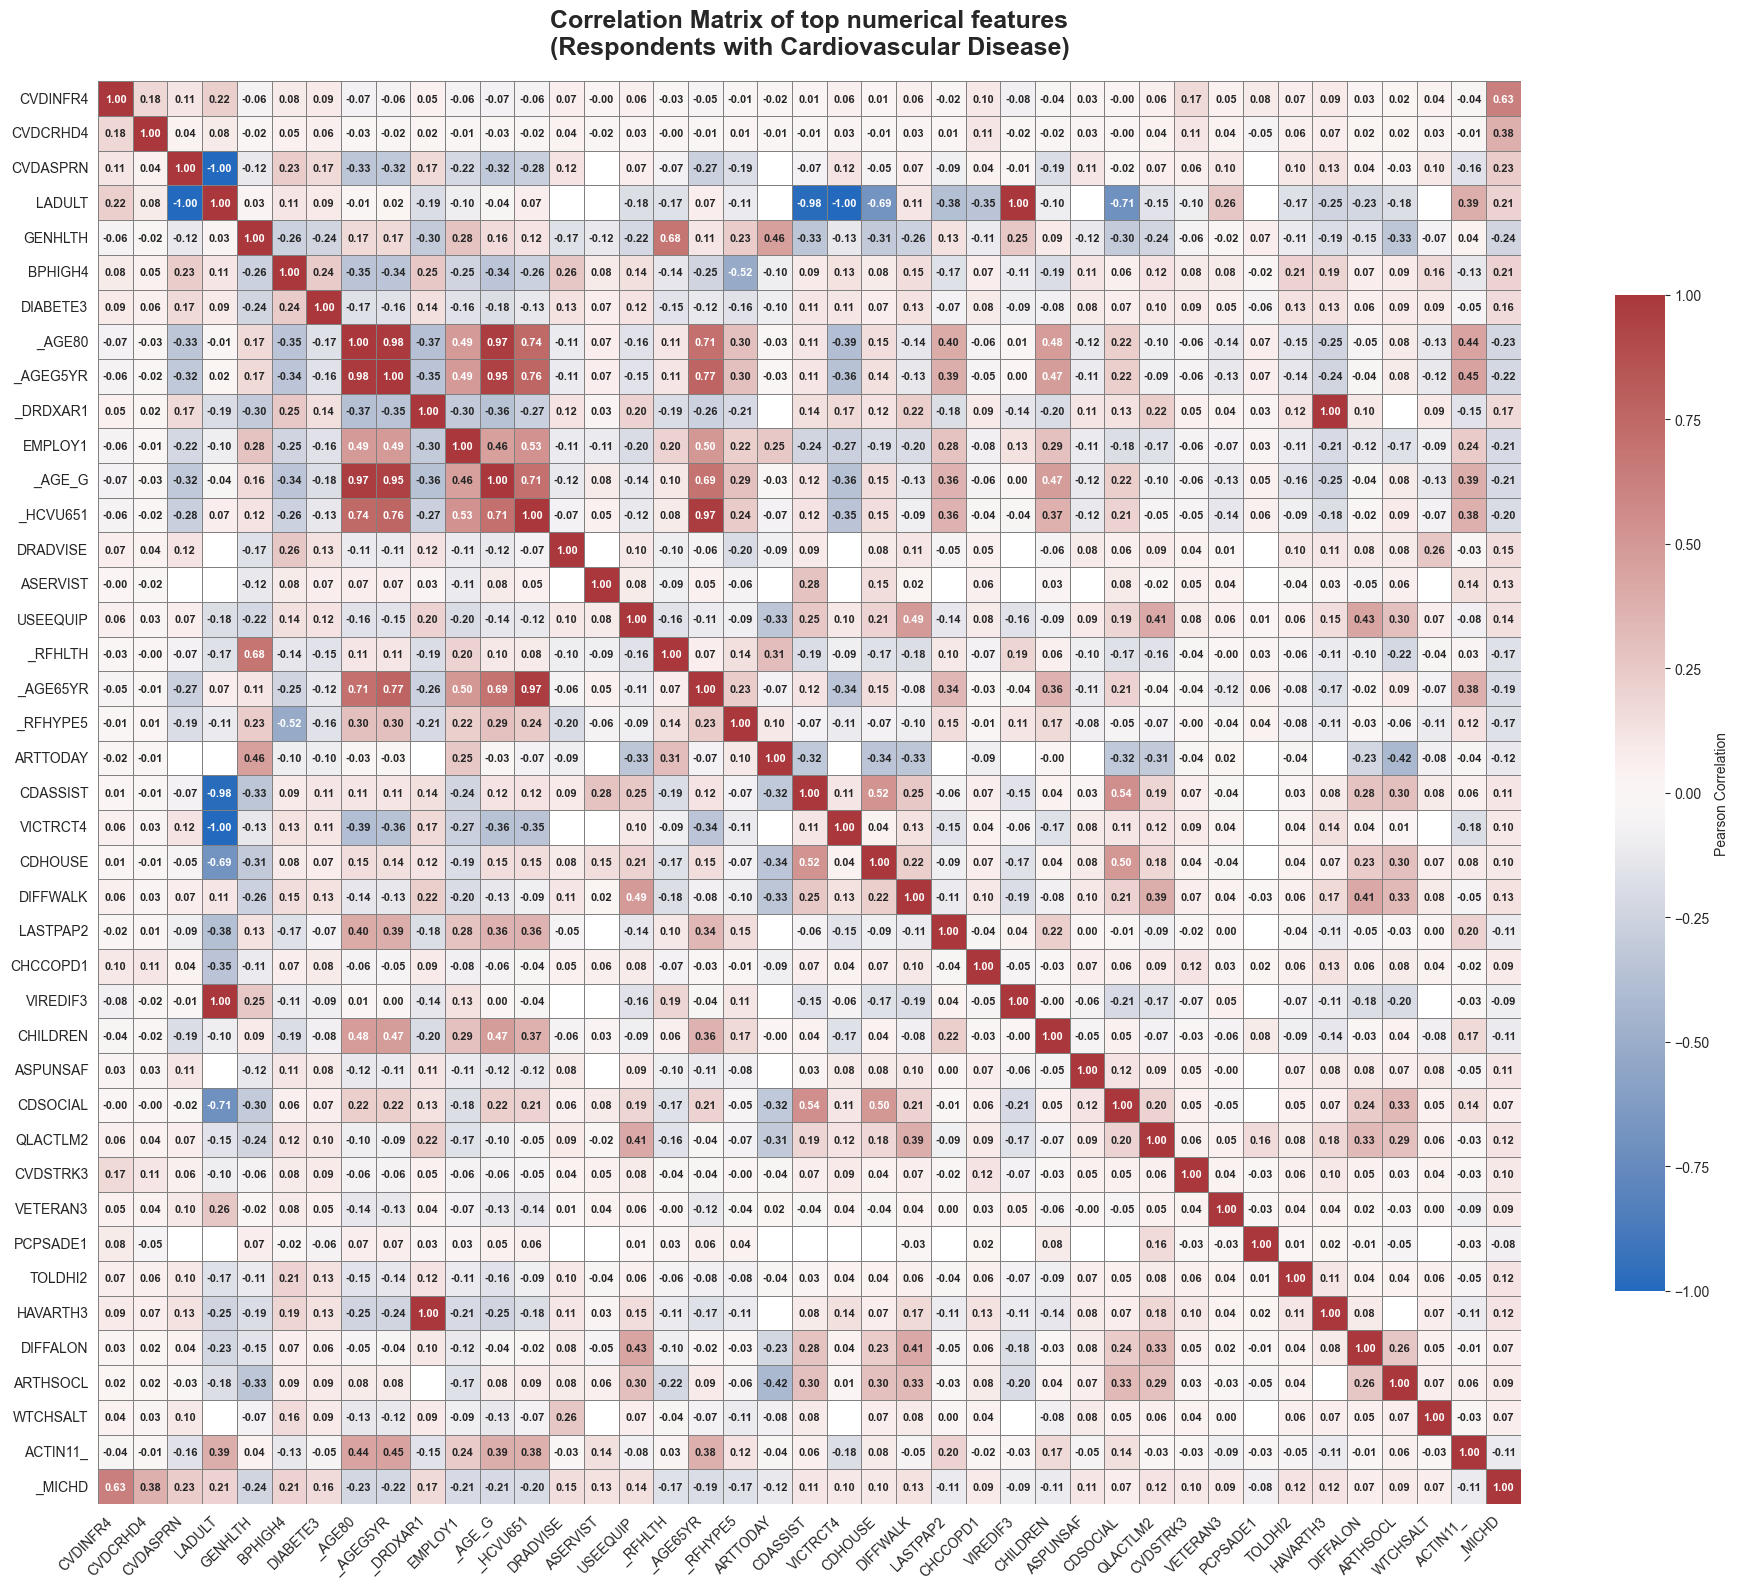

In [35]:
plt.figure(figsize=(20, 16))  # ← crucial for 40 features

num_contain_target = top_num + [target]
corr_matrix = df[num_contain_target].corr().round(2)

# THE WINNING SETUP
sns.heatmap(
    corr_matrix,
    annot=True,                    # shows numbers
    fmt='.2f',                     # 2 decimal places
    cmap='vlag',                   
    center=0,                      # white = zero correlation
    square=True,
    linewidths=0.5,                # thin grid lines = cleaner look
    linecolor='gray',              # subtle grid
    cbar_kws={"shrink": .7, "label": "Pearson Correlation"}, 
    annot_kws={"size": 8, "weight": "bold"},  # readable numbers
)

plt.title('Correlation Matrix of top numerical features\n(Respondents with Cardiovascular Disease)', 
          fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

Các cặp nổi bật:

a) LADULT vs CVDASPRN → -1.00

Tương quan hoàn hảo âm? Không hợp lý về mặt y khoa → có thể là lỗi mã hóa hoặc dữ liệu trùng lặp.

b) CVDASPRN vs CVDCRHD4 → -1.00

→ Cũng là tương quan hoàn hảo âm → rất đáng ngờ.

→ Có thể:

Một biến là bản sao ngược của biến kia.
Hoặc cả hai đều là biến nhị phân, và luôn trái ngược nhau.
Nếu dùng mô hình hồi quy, 2 biến này sẽ gây multicollinearity nghiêm trọng → nên giữ 1, loại 1. 

c) _AGE80 vs _AGE_G → 0.98
→ Hợp lý: cả hai đều đo tuổi → chỉ nên giữ 1 biến (ưu tiên _AGE_G vì có nhiều mức hơn).

d) DIABETE3 vs _AGE_G, _AGE80 → ~0.5–0.6
→ Hợp lý: tuổi càng cao → nguy cơ tiểu đường càng tăng.

e) BPHIGH4 vs GENHLTH → -0.52
→ Hợp lý: huyết áp cao → sức khỏe tổng quát tự đánh giá kém.

f) CHILDREN vs AGE_G → -0.47
→ Hợp lý: người trẻ hơn có nhiều con hơn.

Một số tương quan âm đáng chú ý

CVDINFR4 vs LADULT → -0.71 → người có nhồi máu cơ tim thường ít người lớn hơn? → cần kiểm tra lại.

CVDINFR4 vs CVDASPRN → 0.63 → hợp lý: người có nhồi máu cơ tim thường có tiền sử bệnh tim mạch khác.

đề xuất cho modeling / feature engineering

a) Loại bỏ biến đa cộng tuyến

Giữ 1 trong 2 biến: LADULT và CVDASPRN (vì tương quan -1.00).

Giữ 1 trong 3 biến tuổi: _AGE_G, _AGE80, _AGE65YR.

b) Tạo feature mới

Age × Diabetes: df['AGE_DIAB'] = df['_AGE_G'] * df['DIABETE3']

Hypertension + Diabetes: df['HTN_DM'] = df['BPHIGH4'] + df['DIABETE3']

c) Chuyển sang Spearman correlation nếu nhiều biến rời rạc

Vì nhiều biến trong dataset có thể là ordinal/categorical mã hóa số, Spearman sẽ robust hơn.

Kiểm tra kỹ các cặp biến có tương quan ±1.00 → có thể là lỗi dữ liệu.

1. DifficultyWalking là single best numerical predictor trong nhóm đã có bệnh tim (corr > 0.5 với nhiều biến chức năng).
2. GeneralHealth tự đánh giá vượt trội so với hầu hết bệnh mạn tính riêng lẻ → không được bỏ qua
3. Multimorbidity cluster (Diabetes + Kidney + COPD + Stroke + Arthritis) cực kỳ chặt chẽ → nên tạo feature Comorbidity_Count.
4. Số ngày sức khỏe kém (Physical & Mental) có correlation cao → stress/tâm lý đóng vai trò lớn trong CVD.
5. Người đi khám bác sĩ nhiều lần/năm → proxy cực mạnh cho bệnh nặng (nên giữ và group như đã hướng dẫn).